dataset info

In [1]:
import pandas as pd
import datetime as dt

df = pd.read_excel("RFM_analysis_db.xlsx")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


RFM table: 

In [2]:

df["Revenue"] = df["UnitPrice"] * df["Quantity"]
NOW = df['InvoiceDate'].max()
# Grouping by CustomerID and applying aggregation functions for RFM analysis
RFM_Table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': lambda x: len(x),
    'Revenue': lambda x: x.sum()
})

# Converting InvoiceDate to integer type (days)
RFM_Table['InvoiceDate'] = RFM_Table['InvoiceDate'].astype(int)

# Renaming columns for recency, frequency, and monetary values
RFM_Table.rename(columns={
    'InvoiceDate': 'recency',
    'InvoiceNo': 'frequency',
    'Revenue': 'monetary'
}, inplace=True)




In [3]:
RFM_Table.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


the top customers who have made the highest total purchases

In [4]:
RFM_Table.sort_values(by="monetary",ascending=False).head(5)


,recency,frequency,monetary
CustomerID,,,
14646.0,1,2085,279489.02
18102.0,0,433,256438.49
17450.0,7,351,187482.17
14911.0,0,5903,132572.62
12415.0,23,778,123725.45


We can also observe the statistics of RFM attributes leveraging the describe() function. We will use 25%, 50%, and 75% quantile values of these attributes shortly.

In [5]:
rfm_q = RFM_Table.copy()
rfm_q["r_quartile"] = pd.qcut(rfm_q["recency"], 4, labels=[4,3,2,1])
rfm_q["f_quartile"] = pd.qcut(rfm_q["frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm_q["m_quartile"] = pd.qcut(rfm_q["monetary"], 4, labels=[1,2,3,4])

In [6]:
rfm_q.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,2,0.00,1,1,1
12347.0,1,182,4310.00,4,4,4
12348.0,74,31,1797.24,2,2,4
12349.0,18,73,1757.55,3,3,4
12350.0,309,17,334.40,1,1,2


We add a new column named 'RFM_quartiles' to represent the merged quartile segments for each customer.

In [7]:
rfm_q["RFM_quartiles"] = rfm_q['r_quartile'].astype(str) + rfm_q['f_quartile'].astype(str) + rfm_q['m_quartile'].astype(str)

In [8]:
rfm_q.head(5)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_quartiles
CustomerID,,,,,,,
12346.0,325,2,0.00,1,1,1,111
12347.0,1,182,4310.00,4,4,4,444
12348.0,74,31,1797.24,2,2,4,224
12349.0,18,73,1757.55,3,3,4,334
12350.0,309,17,334.40,1,1,2,112


See the distribution of each segment

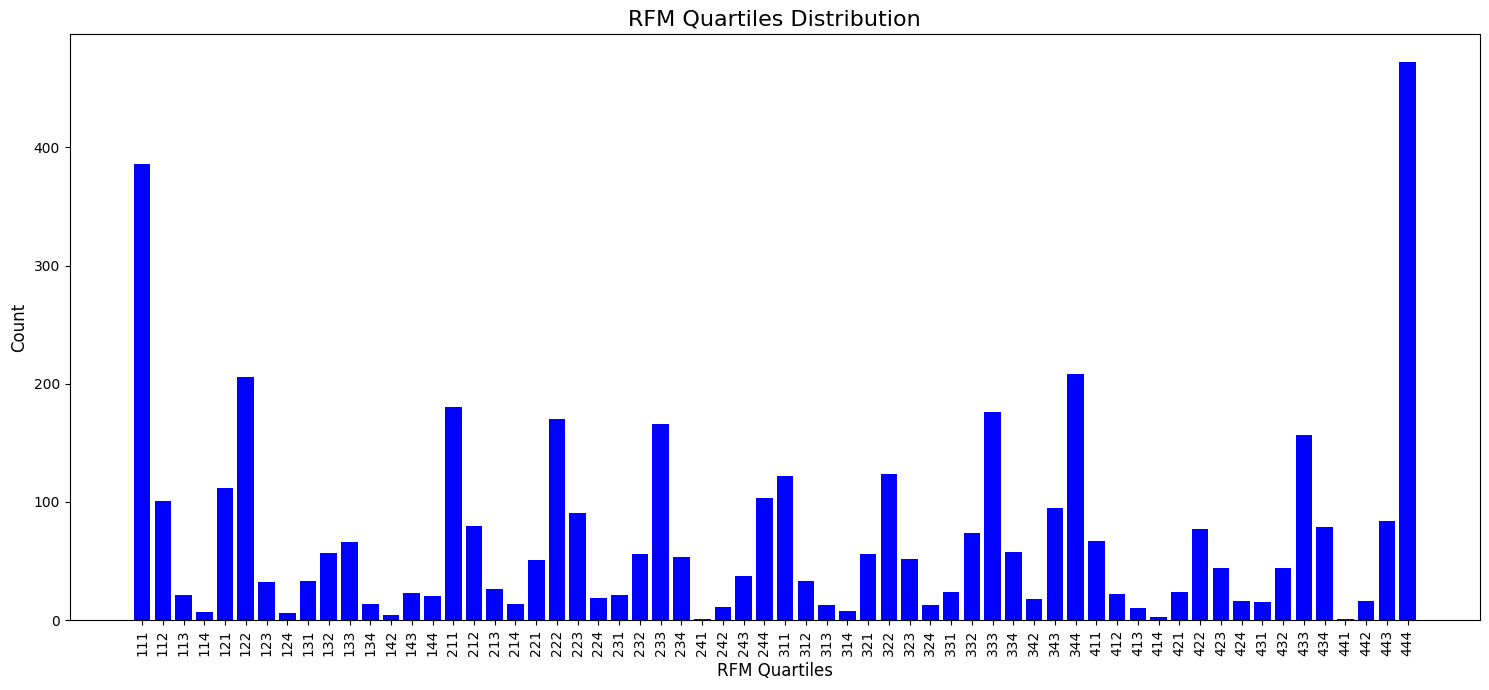

In [9]:
import matplotlib.pyplot as plt

# Đếm số lượng phân bổ của các giá trị RFM_Quartile
rfm_distribution = rfm_q['RFM_quartiles'].value_counts().sort_index()

# Vẽ biểu đồ phân phối
plt.figure(figsize=(15, 7))
plt.bar(rfm_distribution.index, rfm_distribution.values, color='blue')

# Thêm tiêu đề và nhãn trục
plt.title('RFM Quartiles Distribution', fontsize=16)
plt.xlabel('RFM Quartiles', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Xoay nhãn trục x cho dễ đọc
plt.xticks(rotation=90, fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

So, there're 4x4x4=64 values('111' to '444').  However, individually tracking, and devising strategies for each of these 64 segments can become challenging.
We group these segments in a more manageable manner.
We add a final column named "Segments", segment customers by evaluating their RFM_quartiles.

In [10]:
def classifier(rfm):
    if (rfm[0] in ['3', '4']) and (rfm[1] in ['3', '4']) and (rfm[2] in ['3', '4']):
        rfm = "Champions"
    elif (rfm[0] in ['3', '4']) and (rfm[1] in ['3', '4']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Loyal Customers"
    elif (rfm[0] in ['2', '3', '4']) and (rfm[1] in ['2', '3']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Potential Loyalist"
    elif (rfm[0] in ['4']) and (rfm[1] in ['1']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Recent Customers"
    elif (rfm[0] in ['2', '3']) and (rfm[1] in ['2', '3']) and (rfm[2] in ['2', '3']):
        rfm = "Customers Needing Attention"
    elif (rfm[0] in ['2', '3']) and (rfm[1] in ['1', '2', '3', '4']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Still Got Hope"
    elif (rfm[0] in ['1', '2']) and (rfm[1] in ['1', '2', '3', '4']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Need to Get Them Back"
    elif (rfm[0] in ['1']) and (rfm[1] in ['1']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Lost"
    elif (rfm[0] in ['1', '2']) and (rfm[1] in ['1', '2', '3', '4']) and (rfm[2] in ['1', '2', '3', '4']):
        rfm = "Give it a Try"
    return rfm


In [11]:
segmented_rfm = rfm_q.copy()
segmented_rfm["Segments"] = segmented_rfm["RFM_quartiles"].apply(classifier)
segmented_rfm.head(8)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_quartiles,Segments
CustomerID,,,,,,,,
12346.0,325,2,0.00,1,1,1,111,Need to Get Them Back
12347.0,1,182,4310.00,4,4,4,444,Champions
12348.0,74,31,1797.24,2,2,4,224,Potential Loyalist
12349.0,18,73,1757.55,3,3,4,334,Champions
12350.0,309,17,334.40,1,1,2,112,Need to Get Them Back
12352.0,35,95,1545.41,3,3,3,333,Champions
12353.0,203,4,89.00,1,1,1,111,Need to Get Them Back
12354.0,231,58,1079.40,1,3,3,133,Need to Get Them Back


In [12]:
segmented_rfm.groupby('Segments').agg({'recency': 'mean','frequency':'mean', 'monetary':['mean','count']}).round(1)

recency frequency monetary      
                         mean      mean     mean count
Segments                                              
Champions                15.5     217.6   4693.0  1329
Loyal Customers          20.9      77.5    425.3   192
Need to Get Them Back   247.1      29.6    480.4  1088
Potential Loyalist       59.3      38.9    829.5  1033
Recent Customers          8.1       9.3    524.0   102
Still Got Hope           67.9      46.9    873.2   628

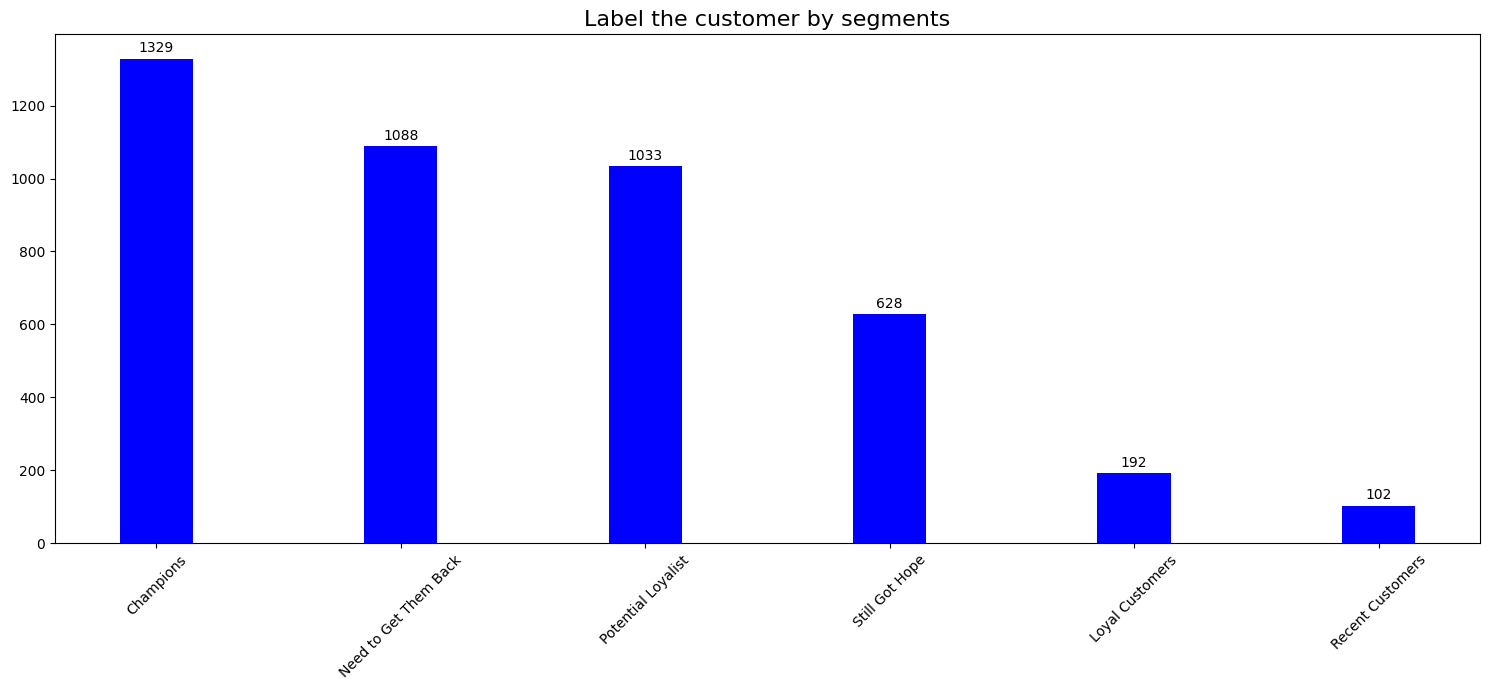

In [13]:
import matplotlib.pyplot as plt

# Đếm số lượng phân bổ của các giá trị RFM_Quartile
rfm_distribution = segmented_rfm['Segments'].value_counts().sort_index()
rfm_distribution=rfm_distribution.sort_values(ascending=False)

# Vẽ biểu đồ phân phối
plt.figure(figsize=(15, 7))
bar_width = 0.3  # Độ rộng các cột
bars = plt.bar(rfm_distribution.index, rfm_distribution.values, color='blue', width=bar_width)

# Thêm chỉ số bên trên các cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, int(yval), ha='center', va='bottom', fontsize=10)

# Thêm tiêu đề và nhãn trục
plt.title('Label the customer by segments', fontsize=16)

# Xoay nhãn trục x cho dễ đọc
plt.xticks(rotation=45, ha='center', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()